In [1]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install tensorflow
# %pip install -U imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Dropout, LayerNormalization, MultiHeadAttention, Input
from tensorflow.keras.layers import Attention, Reshape
from tensorflow.keras.models import Model

In [3]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import models
import utils
import data_processing

In [4]:
COMMODITY = 'copper'

DATE_COLUMN = 'Date'
VALUE_COLUMN = 'Value'  
QUANTITY_COLUMN = 'Std. Quantity (KG)'
UNIT_RATE_COLUMN = 'Std. Unit Rate ($/KG)'
BRENT_OIL_COLUMN = 'Brent Oil Value'
WTI_OIL_COLUMN = 'WTI Oil Value'
SHIP_COUNT_COLUMN = 'ship_count'
PORT_COUNT_COLUMN = 'popular_port_count'

VALUE_SPIKES_COLUMN = 'Value Spikes'  
QUANTITY_SPIKES_COLUMN = 'Std. Quantity (KG) Spikes'
UNIT_RATE_SPIKES_COLUMN = 'Std. Unit Rate ($/KG) Spikes'
BRENT_OIL_SPIKES_COLUMN = 'Brent Oil Value Spikes'
WTI_OIL_SPIKES_COLUMN = 'WTI Oil Value Spikes'
SHIP_COUNT_SPIKES_COLUMN = 'Ship Count Spikes'
PORT_COUNT_SPIKES_COLUMN = 'Port Count Spikes'

FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN,  WTI_OIL_COLUMN, BRENT_OIL_COLUMN, SHIP_COUNT_COLUMN, PORT_COUNT_COLUMN]
# FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN,  WTI_OIL_SPIKES_COLUMN, BRENT_OIL_SPIKES_COLUMN]
# FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN,  WTI_OIL_COLUMN, BRENT_OIL_COLUMN, SHIP_COUNT_SPIKES_COLUMN, PORT_COUNT_SPIKES_COLUMN]
TARGET_COLUMN = 'Price'

ORIGIN_COUNTRY_COLUMN = 'Country of Origin'
DEST_COUNTRY_COLUMN = 'Country of Destination'

PETROL_FILE_PATH = '../../volza/petroleum/petrol_crude_oil_spot_price.csv'
VOLZA_FILE_PATH = f'../../volza/{COMMODITY}/{COMMODITY}.csv'
PRICE_FILE_PATH = f"../../volza/{COMMODITY}/{COMMODITY}_prices.csv"
AIS_POPULAR_FILE_PATH = f'../../ais/ais_ml_features.csv' 

NB_OUTPUT_PATH = f"{COMMODITY}/{COMMODITY}_model_performance (No Balancing).csv"
RUS_OUTPUT_PATH = f"{COMMODITY}/{COMMODITY}_model_performance (Random Under Sampling).csv"
ROS_OUTPUT_PATH = f"{COMMODITY}/{COMMODITY}_model_performance (Random Over Sampling).csv"


SPIKES_THRESHOLD = 2
SPIKES_WINDOW_SIZE = 20
BIN_COUNT = 10
FILL_METHOD = 'ffill'

RANDOM_STATE = 42

## Dataframe Prep

In [5]:
from datetime import datetime

#Formatting the date and price for Volza data
volza_pd = pd.read_csv(VOLZA_FILE_PATH)
volza_pd = volza_pd[(volza_pd["Country of Origin"].notnull()) & (volza_pd["Country of Destination"].notnull())]
volza_pd = volza_pd.rename(columns={'Unnamed: 0': 'ID'})
volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
volza_pd['Date'] = pd.to_datetime(volza_pd['Date'], errors='raise', format='%Y-%m-%d')
volza_pd = utils.convert_to_pound(volza_pd)
volza_pd.head(3)

,0,Date,HS Code,Product Description,Consignee,Notify Party Name,Shipper,Std. Quantity,Std. Unit,Standard Unit Rate INR,...,Freight Term,Marks Number,HS Product Description,Gross Weight,Consignee Address,Shipper Address,Notify Party Address,Country Name,Std. Quantity (KG),Std. Unit Rate ($/KG)
0,1,2019-04-01,74020000,"COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...",NaN,NaN,NaN,0.007,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Lithuania T1 Import,13.999987,5.537862
1,2,2019-04-01,74020000,"COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...",NaN,NaN,NaN,0.021,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,Portugal T1 Import,41.999962,65.516488
2,3,2019-04-01,74020000,"COPPER, UNREFINED; COPPER ANODES FOR ELECTROLY...",NaN,NaN,NaN,0.001,TON,-,...,-,-,NaN,0.0,NaN,NaN,NaN,France T1 Import,1.999998,10.110009


In [6]:
#Preprocessing the AIS data
ais_popular_pd = pd.read_csv(AIS_POPULAR_FILE_PATH)
ais_popular_pd['Date'] = pd.to_datetime(ais_popular_pd['Date'])
ais_popular_pd.head(3)


,Date,ship_count,popular_port,popular_port_count
0,2020-11-10,8,LTKLJ,18
1,2020-11-12,20,IDSKP,8
2,2020-11-29,9,CNSHA,2


In [7]:
#Preprocessing the price data
prices_pd = pd.read_csv(PRICE_FILE_PATH)
prices_pd['Date'] = prices_pd['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y").strftime("%Y-%m-%d"))
prices_pd['Date'] = pd.to_datetime(prices_pd['Date'], errors='raise', format='%Y-%m-%d')
prices_pd['Price'] = prices_pd['Price'].astype(float)  
prices_pd = prices_pd[['Date', 'Price']]
prices_pd

,Date,Price
0,2022-12-30,3.8055
1,2022-12-29,3.8210
2,2022-12-28,3.8320
3,2022-12-27,3.8335
4,2022-12-23,3.8030
...,...,...
1003,2019-01-08,2.6605
1004,2019-01-07,2.6410
1005,2019-01-04,2.6515
1006,2019-01-03,2.5705


In [8]:
#Aggregate volza data by day
date_wise_volza = volza_pd.groupby("Date")[[VALUE_COLUMN,QUANTITY_COLUMN,'Gross Weight']].sum()

In [9]:
# Avg of Commodity Price in Volza
avg_price_volza = volza_pd.groupby('Date')[UNIT_RATE_COLUMN].mean()
date_wise_volza = date_wise_volza.join(avg_price_volza, how='left')
date_wise_volza

,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG)
Date,,,,
2019-01-01,3.580679e+08,1.115013e+08,512426.9,23.234310
2019-01-02,2.899774e+07,9.930702e+06,4507752.0,2.912255
2019-01-03,1.652543e+07,5.351697e+06,2428782.0,4.118381
2019-01-04,1.381037e+05,4.362061e+04,0.0,2.563629
2019-01-06,1.854971e+07,6.670174e+06,0.0,1790.400393
...,...,...,...,...
2022-12-28,3.660210e+07,1.011938e+07,2301364.0,3.447410
2022-12-29,9.597299e+06,5.367289e+06,2415.6,6.130818
2022-12-30,1.148950e+08,5.010989e+06,360.0,168.297919


In [10]:
# Petroleum data prep
petrol_df = pd.read_csv(PETROL_FILE_PATH, delimiter=';', on_bad_lines='warn')
petrol_df['Date'] = pd.to_datetime(petrol_df['Date'])

# Split based on types of oil
brent_df = petrol_df[petrol_df['product-name']=='UK Brent Crude Oil']
wti_df = petrol_df[petrol_df['product-name']=='WTI Crude Oil']

brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


C:\Users\manim\AppData\Local\Temp\ipykernel_9692\273638861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
C:\Users\manim\AppData\Local\Temp\ipykernel_9692\273638861.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


In [11]:
# Combining dataframes
prices_pd = prices_pd.set_index('Date')
ais_popular_pd = ais_popular_pd.set_index('Date')
date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method=FILL_METHOD)
aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method=FILL_METHOD)
aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
aggregated_df = aggregated_df.merge(wti_df[[DATE_COLUMN, WTI_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
aggregated_df

C:\Users\manim\AppData\Local\Temp\ipykernel_9692\1674725426.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_9692\1674725426.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_9692\1674725426.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_9692\1674725426.py:7: FutureWarnin

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),ship_count,popular_port,popular_port_count,Price,Brent Oil Value,WTI Oil Value
0,2019-01-01,3.580679e+08,1.115013e+08,512426.9,23.234310,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,2.899774e+07,9.930702e+06,4507752.0,2.912255,NaN,NaN,NaN,2.6250,54.06,46.31
2,2019-01-03,1.652543e+07,5.351697e+06,2428782.0,4.118381,NaN,NaN,NaN,2.5705,53.23,46.92
3,2019-01-04,1.381037e+05,4.362061e+04,0.0,2.563629,NaN,NaN,NaN,2.6515,55.64,47.76
4,2019-01-06,1.854971e+07,6.670174e+06,0.0,1790.400393,NaN,NaN,NaN,2.6515,55.64,47.76
...,...,...,...,...,...,...,...,...,...,...,...
1233,2022-12-28,3.660210e+07,1.011938e+07,2301364.0,3.447410,26021.0,SGSIN,9233.0,3.8320,81.70,78.89
1234,2022-12-29,9.597299e+06,5.367289e+06,2415.6,6.130818,24039.0,SGSIN,8861.0,3.8210,80.96,78.43
1235,2022-12-30,1.148950e+08,5.010989e+06,360.0,168.297919,19952.0,SGSIN,8118.0,3.8055,82.82,80.16
1236,2022-12-31,1.290664e+07,3.340804e+06,0.0,3.758166,8925.0,USMSY,2673.0,3.8055,82.82,80.16


In [12]:
def detect_spikes(df, column, window_size):
    ## Detecting spikes
    moving_avg = df[column].rolling(window=window_size).mean()
    std_dev = df[column].rolling(window=window_size).std()

    # Set a threshold to identify spikes
    return (abs(aggregated_df[column] - moving_avg) > SPIKES_THRESHOLD * std_dev).astype(int)

# aggregated_df['spikes'] = detect_spikes(aggregated_df, 'Price')
# print("SPIKES : NON SPIKES = ")
# print(aggregated_df['spikes'].value_counts())
# print("PERCENT OF SPIKES", aggregated_df['spikes'].value_counts()[1]/len(aggregated_df))

# **Detect spikes**

In [13]:
# aggregated_df[VALUE_SPIKES_COLUMN] = detect_spikes(aggregated_df, VALUE_COLUMN)
# aggregated_df[QUANTITY_SPIKES_COLUMN] = detect_spikes(aggregated_df, QUANTITY_COLUMN)
# aggregated_df[UNIT_RATE_SPIKES_COLUMN] = detect_spikes(aggregated_df, UNIT_RATE_COLUMN)
# aggregated_df[WTI_OIL_SPIKES_COLUMN] = detect_spikes(aggregated_df, WTI_OIL_COLUMN)
# aggregated_df[BRENT_OIL_SPIKES_COLUMN] = detect_spikes(aggregated_df, BRENT_OIL_COLUMN)
# aggregated_df[SHIP_COUNT_SPIKES_COLUMN] = detect_spikes(aggregated_df, SHIP_COUNT_COLUMN)
# aggregated_df[PORT_COUNT_SPIKES_COLUMN] = detect_spikes(aggregated_df, PORT_COUNT_COLUMN)

# #Visualise Dataset

# # Plotting the graph
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
# ax1.plot(aggregated_df.index, aggregated_df[VALUE_SPIKES_COLUMN], label='Value Spikes', color='b')
# ax1.plot(aggregated_df.index, aggregated_df[QUANTITY_SPIKES_COLUMN], label='Quantity Spikes', color='g')
# ax1.plot(aggregated_df.index, aggregated_df[UNIT_RATE_SPIKES_COLUMN], label='Unit Rate Spikes', color='k')
# ax1.plot(aggregated_df.index, aggregated_df[BRENT_OIL_SPIKES_COLUMN], label='Brent Oil Value Spikes', color='m')
# ax1.plot(aggregated_df.index, aggregated_df[WTI_OIL_SPIKES_COLUMN], label='WTI Oil Value Spikes', color='c')
# ax1.plot(aggregated_df.index, aggregated_df[SHIP_COUNT_COLUMN], label='Ship Count Spikes', color='darkorange')
# ax1.plot(aggregated_df.index, aggregated_df[PORT_COUNT_COLUMN], label='Port Count Value Spikes', color='violet')

# ax1.set_xlabel('Date')
# ax1.set_ylabel('Value / Quantity / Gross Weight / Brent Oil Value / WTI Oil Value / Ship Count / Port Count ', color='b')
# ax1.tick_params('y', colors='b')

# # Creating a second y-axis for 'Price'
# ax2 = ax1.twinx()
# ax2.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='orange')
# ax2.set_ylabel('Price', color='orange')
# ax2.tick_params('y', colors='orange')

# # Display legend
# fig.tight_layout()
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# # Display the graph
# # plt.show()

In [14]:
#remove date 2020-01-01
aggregated_df = aggregated_df[aggregated_df.index != '2020-01-01']
aggregated_df

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),ship_count,popular_port,popular_port_count,Price,Brent Oil Value,WTI Oil Value
0,2019-01-01,3.580679e+08,1.115013e+08,512426.9,23.234310,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,2.899774e+07,9.930702e+06,4507752.0,2.912255,NaN,NaN,NaN,2.6250,54.06,46.31
2,2019-01-03,1.652543e+07,5.351697e+06,2428782.0,4.118381,NaN,NaN,NaN,2.5705,53.23,46.92
3,2019-01-04,1.381037e+05,4.362061e+04,0.0,2.563629,NaN,NaN,NaN,2.6515,55.64,47.76
4,2019-01-06,1.854971e+07,6.670174e+06,0.0,1790.400393,NaN,NaN,NaN,2.6515,55.64,47.76
...,...,...,...,...,...,...,...,...,...,...,...
1233,2022-12-28,3.660210e+07,1.011938e+07,2301364.0,3.447410,26021.0,SGSIN,9233.0,3.8320,81.70,78.89
1234,2022-12-29,9.597299e+06,5.367289e+06,2415.6,6.130818,24039.0,SGSIN,8861.0,3.8210,80.96,78.43
1235,2022-12-30,1.148950e+08,5.010989e+06,360.0,168.297919,19952.0,SGSIN,8118.0,3.8055,82.82,80.16
1236,2022-12-31,1.290664e+07,3.340804e+06,0.0,3.758166,8925.0,USMSY,2673.0,3.8055,82.82,80.16


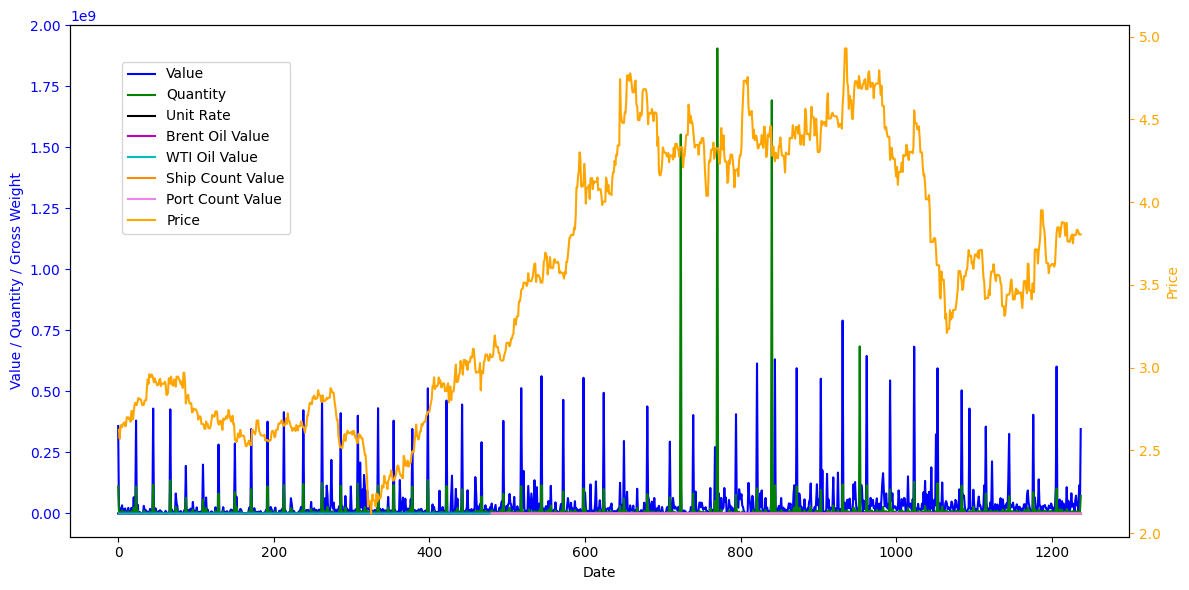

In [15]:
#Visualise Dataset
# Plotting the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
ax1.plot(aggregated_df.index, aggregated_df[VALUE_COLUMN], label='Value', color='b')
ax1.plot(aggregated_df.index, aggregated_df[QUANTITY_COLUMN], label='Quantity', color='g')
ax1.plot(aggregated_df.index, aggregated_df[UNIT_RATE_COLUMN], label='Unit Rate', color='k')
ax1.plot(aggregated_df.index, aggregated_df[BRENT_OIL_COLUMN], label='Brent Oil Value', color='m')
ax1.plot(aggregated_df.index, aggregated_df[WTI_OIL_COLUMN], label='WTI Oil Value', color='c')
ax1.plot(aggregated_df.index, aggregated_df[SHIP_COUNT_COLUMN], label='Ship Count Value', color='darkorange')
ax1.plot(aggregated_df.index, aggregated_df[PORT_COUNT_COLUMN], label='Port Count Value', color='violet')

ax1.set_xlabel('Date')
ax1.set_ylabel('Value / Quantity / Gross Weight', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='orange')
ax2.set_ylabel('Price', color='orange')
ax2.tick_params('y', colors='orange')

# Display legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the graph
# plt.show()

In [16]:
# # Plotting the price data
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
# plt.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='blue')

# # Highlighting spikes
# spike_indices = aggregated_df[aggregated_df['spikes'] == 1].index
# spike_prices = aggregated_df.loc[spike_indices, 'Price']
# plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Spikes')

# # Adding labels and title
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Price Data with Spikes')
# plt.legend()

# # Display the plot
# # plt.show()

## Baseline

In [17]:
# # Count % of spikes 
# total_spikes = aggregated_df['spikes'].sum()
# total_data_points = len(aggregated_df)
# percentage_of_spikes = (total_spikes / total_data_points) * 100

# print(f"Percentage of Spikes: {percentage_of_spikes:.2f}%")

In [18]:
# from sklearn.metrics import precision_score, recall_score

# # Probability of spike
# spike_prob = aggregated_df['spikes'].mean()

# # Random baseline predictions
# random_predictions = np.random.choice([0, 1], size=len(aggregated_df), p=[1-spike_prob, spike_prob])

# # Calculate precision and recall for the random baseline
# random_precision = precision_score(aggregated_df['spikes'], random_predictions)
# random_recall = recall_score(aggregated_df['spikes'], random_predictions)

# print(f"Random Guessing Precision: {random_precision}")
# print(f"Random Guessing Recall: {random_recall}")


## Data Prep for Classification

In [19]:
COLUMNS = FEATURE_COLUMNS + [TARGET_COLUMN]
print(COLUMNS)

['Value', 'Std. Quantity (KG)', 'Std. Unit Rate ($/KG)', 'WTI Oil Value', 'Brent Oil Value', 'ship_count', 'popular_port_count', 'Price']


In [20]:
# # Discretize
# from sklearn.preprocessing import KBinsDiscretizer

# def discretize(df, columns, bins):
#     est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
#     df[columns] = est.fit_transform(df[columns])
#     return df

# # FEATURES_1 = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN]
# # FEATURES_2 = [WTI_OIL_COLUMN, BRENT_OIL_COLUMN]

# test_df = aggregated_df.copy()
# test_df[FEATURE_COLUMNS] = test_df[FEATURE_COLUMNS].fillna(0)

# # test_df = discretize(test_df, FEATURES_1, 2)
# # test_df = discretize(test_df, FEATURES_2, BIN_COUNT)
# discretized_df = discretize(test_df, FEATURE_COLUMNS, BIN_COUNT)
# # discretized_df = test_df.copy()
# test_df.head(2)


In [21]:
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
# ax1.plot(test_df.index, test_df[VALUE_COLUMN], label='Value', color='b')
# ax1.plot(test_df.index, test_df[QUANTITY_COLUMN], label='Quantity', color='g')
# ax1.plot(test_df.index, test_df[UNIT_RATE_COLUMN], label='Unit Rate', color='k')
# ax1.plot(test_df.index, test_df[BRENT_OIL_COLUMN], label='Brent Oil Value', color='m')
# ax1.plot(test_df.index, test_df[WTI_OIL_COLUMN], label='WTI Oil Value', color='c')
# ax1.plot(test_df.index, test_df[SHIP_COUNT_COLUMN], label='Ship Count Value', color='darkorange')
# ax1.plot(test_df.index, test_df[PORT_COUNT_COLUMN], label='Port Count Value', color='violet')

# ax1.set_xlabel('Date')
# ax1.set_ylabel('Value / Quantity / Gross Weight', color='b')
# ax1.tick_params('y', colors='b')

# # Creating a second y-axis for 'Price'
# ax2 = ax1.twinx()
# ax2.plot(test_df.index, test_df['Price'], label='Price', color='orange')
# ax2.set_ylabel('Price', color='orange')
# ax2.tick_params('y', colors='orange')

# # Display legend
# fig.tight_layout()
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# # Display the graph
# plt.show()

In [22]:
# # Convert the discretized data into a DataFrame
# discretized_df = pd.DataFrame(discretized_df, columns=FEATURE_COLUMNS)

# unique_values = discretized_df[VALUE_COLUMN].fillna(method=FILL_METHOD).unique()
# print(unique_values)

# bin_counts = {col: discretized_df[col].value_counts() for col in FEATURE_COLUMNS}

# # Plotting
# plt.figure(figsize=(15, len(FEATURE_COLUMNS) * 5))

# for i, column in enumerate(FEATURE_COLUMNS):
#     plt.subplot(len(FEATURE_COLUMNS), 1, i + 1)
#     bin_counts[column].sort_index().plot(kind='bar', ax=plt.gca())

#     plt.title(f'{column} Distribution')
#     plt.ylabel('Frequency')
#     plt.xlabel('Bins')

# plt.tight_layout()
# plt.show()


In [23]:
# Clean up before passing to Arima
initial_row_count = aggregated_df.shape[0]

columns_of_interest = ['Price']  # Add other columns as necessary

aggregated_df = aggregated_df.dropna(subset=columns_of_interest)

rows_dropped = initial_row_count - aggregated_df.shape[0]

print(f"Rows dropped due to NaN values: {rows_dropped}")

Rows dropped due to NaN values: 1


## Train / Test Set Up

In [24]:
from sklearn.model_selection import train_test_split
import pmdarima as pm

# Fit an Auto ARIMA model to the 'Price' series
model = pm.auto_arima(aggregated_df['Price'], seasonal=True, m=12, suppress_warnings=True, stepwise=True, error_action='ignore')

# Forecast the series using the model (in-sample prediction)
forecast = model.predict_in_sample()

# Calculate residuals (difference between actual and forecasted values)
residuals = aggregated_df['Price'] - forecast

# Append residuals to DataFrame as a new feature (using residuals as a way to detect spike / anomaly)
aggregated_df = aggregated_df.copy()
aggregated_df['ARIMA_Residuals'] = residuals

In [25]:
# Trying out different window sizes
SPIKE_WINDOW_SIZES = [10, 20, 30, 40, 60, 80, 100]
results_dfs = []

for window_size in SPIKE_WINDOW_SIZES:
    print(f"Evaluating window size: {window_size}")

    aggregated_df['spikes'] = detect_spikes(aggregated_df, 'Price', window_size)

    # Prepare features and target
    FEATURE_COLUMNS = [TARGET_COLUMN, 'ARIMA_Residuals']  # Adjust as needed
    X, y = data_processing.prepare_features_and_target(aggregated_df, FEATURE_COLUMNS, 'spikes')

    # Split data 
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=False)

    # Scale features
    X_train_scaled, X_test_scaled = data_processing.scale_features(X_train_raw, X_test_raw)

    # Create sequences
    X_train, y_train = data_processing.create_sequences(X_train_scaled, y_train, window_size)
    X_test, y_test = data_processing.create_sequences(X_test_scaled, y_test, window_size)

    print(f'X train shape: {X_train.shape}')

    output_file_path = f'{COMMODITY}/results_{window_size}.csv'
    pred_file_path = f'{COMMODITY}/predictions/{window_size}'
    results_df = models.evaluate_all(X_train, y_train, X_test, y_test, output_file_path, pred_file_path)
    results_df['Window Size'] = window_size
    results_dfs.append(results_df)

Evaluating window size: 10
X train shape: (980, 10, 2)



8/8 [==============================] - 0s 4ms/step
Predictions saved to CSV file: copper/predictions/10/LSTM_250_layers_predictions.csv
Predictions saved to NPY file: copper/predictions/10/LSTM_250_layers_predictions.npy
8/8 [==============================] - 1s 5ms/step
Predictions saved to CSV file: copper/predictions/10/LSTM_200_layers_predictions.csv
Predictions saved to NPY file: copper/predictions/10/LSTM_200_layers_predictions.npy
8/8 [==============================] - 0s 3ms/step
Predictions saved to CSV file: copper/predictions/10/LSTM_100_layers_predictions.csv
Predictions saved to NPY file: copper/predictions/10/LSTM_100_layers_predictions.npy
8/8 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/predictions/10/LSTM_50_layers_predictions.csv
Predictions saved to NPY file: copper/predictions/10/LSTM_50_layers_predictions.npy


8/8 [==============================] - 0s 1ms/step
 2. Fai

## Evaluation

In [ ]:
# Display all results df
for idx, df in enumerate(results_dfs):
    print(f"Results for window size: {SPIKE_WINDOW_SIZES[idx]}")
    display(df) 

Results for window size: 10


,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Window Size
0,LSTM,250 layers,0.962343,0.973684,0.986667,0.980132,0.727273,0.571429,0.640000,10
1,LSTM,200 layers,0.962343,0.973684,0.986667,0.980132,0.727273,0.571429,0.640000,10
2,LSTM,100 layers,0.953975,0.977679,0.973333,0.975501,0.600000,0.642857,0.620690,10
3,LSTM,50 layers,0.953975,0.981982,0.968889,0.975391,0.588235,0.714286,0.645161,10
4,CNN with Attention,"32 filters, kernel size 7",0.966527,0.986547,0.977778,0.982143,0.687500,0.785714,0.733333,10
5,CNN with Attention,"32 filters, kernel size 5",0.970711,0.986607,0.982222,0.984410,0.733333,0.785714,0.758621,10
6,CNN with Attention,"32 filters, kernel size 3",0.970711,0.982301,0.986667,0.984479,0.769231,0.714286,0.740741,10
7,CNN with Attention,"64 filters, kernel size 7",0.970711,0.986607,0.982222,0.984410,0.733333,0.785714,0.758621,10
8,CNN with Attention,"64 filters, kernel size 5",0.970711,0.986607,0.982222,0.984410,0.733333,0.785714,0.758621,10
9,CNN with Attention,"64 filters, kernel size 3",0.983264,0.986784,0.995556,0.991150,0.916667,0.785714,0.846154,10


Results for window size: 20


,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Window Size
0,LSTM,250 layers,0.921397,0.952153,0.961353,0.956731,0.600000,0.545455,0.571429,20
1,LSTM,200 layers,0.934498,0.970588,0.956522,0.963504,0.640000,0.727273,0.680851,20
2,LSTM,100 layers,0.925764,0.965686,0.951691,0.958637,0.600000,0.681818,0.638298,20
3,LSTM,50 layers,0.873362,0.949495,0.908213,0.928395,0.387097,0.545455,0.452830,20
4,CNN with Attention,"32 filters, kernel size 7",0.943231,0.970874,0.966184,0.968523,0.695652,0.727273,0.711111,20
5,CNN with Attention,"32 filters, kernel size 5",0.943231,0.966346,0.971014,0.968675,0.714286,0.681818,0.697674,20
6,CNN with Attention,"32 filters, kernel size 3",0.947598,0.962085,0.980676,0.971292,0.777778,0.636364,0.700000,20
7,CNN with Attention,"64 filters, kernel size 7",0.947598,0.975610,0.966184,0.970874,0.708333,0.772727,0.739130,20
8,CNN with Attention,"64 filters, kernel size 5",0.951965,0.957944,0.990338,0.973872,0.866667,0.590909,0.702703,20
9,CNN with Attention,"64 filters, kernel size 3",0.960699,0.962617,0.995169,0.978622,0.933333,0.636364,0.756757,20


Results for window size: 30


,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Window Size
0,LSTM,250 layers,0.917808,0.968254,0.938462,0.953125,0.600000,0.750000,0.666667,30
1,LSTM,200 layers,0.894977,0.962366,0.917949,0.939633,0.515152,0.708333,0.596491,30
2,LSTM,100 layers,0.917808,0.949239,0.958974,0.954082,0.636364,0.583333,0.608696,30
3,LSTM,50 layers,0.876712,0.942105,0.917949,0.929870,0.448276,0.541667,0.490566,30
4,CNN with Attention,"32 filters, kernel size 7",0.958904,0.969697,0.984615,0.977099,0.857143,0.750000,0.800000,30
5,CNN with Attention,"32 filters, kernel size 5",0.926941,0.973545,0.943590,0.958333,0.633333,0.791667,0.703704,30
6,CNN with Attention,"32 filters, kernel size 3",0.931507,0.963918,0.958974,0.961440,0.680000,0.708333,0.693878,30
7,CNN with Attention,"64 filters, kernel size 7",0.949772,0.955446,0.989744,0.972292,0.882353,0.625000,0.731707,30
8,CNN with Attention,"64 filters, kernel size 5",0.945205,0.964467,0.974359,0.969388,0.772727,0.708333,0.739130,30
9,CNN with Attention,"64 filters, kernel size 3",0.949772,0.964646,0.979487,0.972010,0.809524,0.708333,0.755556,30


Results for window size: 40


,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Window Size
0,LSTM,250 layers,0.899522,0.966102,0.919355,0.942149,0.531250,0.739130,0.618182,40
1,LSTM,200 layers,0.827751,0.936047,0.865591,0.899441,0.324324,0.521739,0.400000,40
2,LSTM,100 layers,0.880383,0.970760,0.892473,0.929972,0.473684,0.782609,0.590164,40
3,LSTM,50 layers,0.822967,0.962733,0.833333,0.893372,0.354167,0.739130,0.478873,40
4,CNN with Attention,"32 filters, kernel size 7",0.913876,0.942105,0.962366,0.952128,0.631579,0.521739,0.571429,40
5,CNN with Attention,"32 filters, kernel size 5",0.904306,0.936842,0.956989,0.946809,0.578947,0.478261,0.523810,40
6,CNN with Attention,"32 filters, kernel size 3",0.942584,0.957895,0.978495,0.968085,0.789474,0.652174,0.714286,40
7,CNN with Attention,"64 filters, kernel size 7",0.918660,0.942408,0.967742,0.954907,0.666667,0.521739,0.585366,40
8,CNN with Attention,"64 filters, kernel size 5",0.918660,0.937824,0.973118,0.955145,0.687500,0.478261,0.564103,40
9,CNN with Attention,"64 filters, kernel size 3",0.928230,0.938462,0.983871,0.960630,0.785714,0.478261,0.594595,40


Results for window size: 60


,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Window Size
0,LSTM,250 layers,0.862434,0.885057,0.96250,0.922156,0.600000,0.310345,0.409091,60
1,LSTM,200 layers,0.862434,0.876404,0.97500,0.923077,0.636364,0.241379,0.350000,60
2,LSTM,100 layers,0.862434,0.952703,0.88125,0.915584,0.536585,0.758621,0.628571,60
3,LSTM,50 layers,0.878307,0.965986,0.88750,0.925081,0.571429,0.827586,0.676056,60
4,CNN with Attention,"32 filters, kernel size 7",0.878307,0.878453,0.99375,0.932551,0.875000,0.241379,0.378378,60
5,CNN with Attention,"32 filters, kernel size 5",0.883598,0.892045,0.98125,0.934524,0.769231,0.344828,0.476190,60
6,CNN with Attention,"32 filters, kernel size 3",0.857143,0.884393,0.95625,0.918919,0.562500,0.310345,0.400000,60
7,CNN with Attention,"64 filters, kernel size 7",0.867725,0.885714,0.96875,0.925373,0.642857,0.310345,0.418605,60
8,CNN with Attention,"64 filters, kernel size 5",0.862434,0.880682,0.96875,0.922619,0.615385,0.275862,0.380952,60
9,CNN with Attention,"64 filters, kernel size 3",0.825397,0.862857,0.94375,0.901493,0.357143,0.172414,0.232558,60


Results for window size: 80


,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Window Size
0,LSTM,250 layers,0.934911,0.974843,0.956790,0.965732,0.300000,0.428571,0.352941,80
1,LSTM,200 layers,0.840237,0.992701,0.839506,0.909699,0.187500,0.857143,0.307692,80
2,LSTM,100 layers,0.917160,0.986842,0.925926,0.955414,0.294118,0.714286,0.416667,80
3,LSTM,50 layers,0.934911,1.000000,0.932099,0.964856,0.388889,1.000000,0.560000,80
4,CNN with Attention,"32 filters, kernel size 7",0.940828,0.993506,0.944444,0.968354,0.400000,0.857143,0.545455,80
5,CNN with Attention,"32 filters, kernel size 5",0.928994,0.993421,0.932099,0.961783,0.352941,0.857143,0.500000,80
6,CNN with Attention,"32 filters, kernel size 3",0.917160,0.986842,0.925926,0.955414,0.294118,0.714286,0.416667,80
7,CNN with Attention,"64 filters, kernel size 7",0.958580,0.993631,0.962963,0.978056,0.500000,0.857143,0.631579,80
8,CNN with Attention,"64 filters, kernel size 5",0.905325,0.980263,0.919753,0.949045,0.235294,0.571429,0.333333,80
9,CNN with Attention,"64 filters, kernel size 3",0.840237,0.978723,0.851852,0.910891,0.142857,0.571429,0.228571,80


Results for window size: 100


,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Window Size
0,LSTM,250 layers,0.953020,0.971631,0.978571,0.975089,0.625000,0.555556,0.588235,100
1,LSTM,200 layers,0.932886,0.957746,0.971429,0.964539,0.428571,0.333333,0.375000,100
2,LSTM,100 layers,0.939597,0.964539,0.971429,0.967972,0.500000,0.444444,0.470588,100
3,LSTM,50 layers,0.912752,0.977444,0.928571,0.952381,0.375000,0.666667,0.480000,100
4,CNN with Attention,"32 filters, kernel size 7",0.899329,0.977099,0.914286,0.944649,0.333333,0.666667,0.444444,100
5,CNN with Attention,"32 filters, kernel size 5",0.939597,0.978102,0.957143,0.967509,0.500000,0.666667,0.571429,100
6,CNN with Attention,"32 filters, kernel size 3",0.865772,0.968750,0.885714,0.925373,0.238095,0.555556,0.333333,100
7,CNN with Attention,"64 filters, kernel size 7",0.832215,0.975207,0.842857,0.904215,0.214286,0.666667,0.324324,100
8,CNN with Attention,"64 filters, kernel size 5",0.845638,0.975610,0.857143,0.912548,0.230769,0.666667,0.342857,100
9,CNN with Attention,"64 filters, kernel size 3",0.872483,0.954887,0.907143,0.930403,0.187500,0.333333,0.240000,100


## Save Predictions

In [ ]:
def save_predictions_to_file(model_name, y_pred, y_true=None, file_format="npy"):
    if file_format == "npy":
        # Save as NumPy binary file
        np.save(f"results/{COMMODITY}/pred/{model_name}_predictions.npy", y_pred)
        if y_true is not None:
            np.save(f"results/{COMMODITY}/true/{model_name}_true_labels.npy", y_true)
    elif file_format == "csv":
        # Save as CSV for easier readability
        df = pd.DataFrame({"Predictions": y_pred.flatten()})
        if y_true is not None:
            df["True Labels"] = y_true
        df.to_csv(f"results/{COMMODITY}/.csv/{model_name}_predictions.csv", index=False)
    else:
        raise ValueError("Unsupported file format. Use 'npy' or 'csv'.")

### **Random Under Sampling**

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler


# time_series_df = aggregated_df.copy()

# # Drop rows with NaN in the 'spikes' column
# time_series_df = time_series_df.dropna(subset=['spikes'])
# discretized_df = discretize(time_series_df[FEATURE_COLUMNS], FEATURE_COLUMNS, BIN_COUNT)
# time_series_df[FEATURE_COLUMNS] = discretized_df

# # Extract features and target variable BEFORE creating sequences
# X = time_series_df[FEATURE_COLUMNS].values
# y = time_series_df['spikes'].values

# # Feature scaling using StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply RandomOverSampler BEFORE creating sequences
# random_under_sampler = RandomUnderSampler(random_state=RANDOM_STATE)
# X_scaled_resampled, y_resampled = random_under_sampler.fit_resample(X_scaled, y)

# # Recreate sequences with resampled data
# X_sequences_resampled, y_sequences_resampled = [], []
# for i in range(len(X_scaled_resampled) - SPIKES_WINDOW_SIZE + 1):
#     X_sequences_resampled.append(X_scaled_resampled[i:i + SPIKES_WINDOW_SIZE, :])
#     y_sequences_resampled.append(y_resampled[i + SPIKES_WINDOW_SIZE - 1])

# X_sequences_resampled, y_sequences_resampled = np.array(X_sequences_resampled), np.array(y_sequences_resampled)

# # Split the resampled sequences into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sequences_resampled, y_sequences_resampled, test_size=0.2, random_state=50)

# # Proceed with model training and evaluation
# evaluate_all_models(RUS_OUTPUT_PATH)


### **Random Over Sampling**

In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# time_series_df = aggregated_df.copy()

# # Drop rows with NaN in the 'spikes' column
# time_series_df = time_series_df.dropna(subset=['spikes'])
# discretized_df = discretize(time_series_df[FEATURE_COLUMNS], FEATURE_COLUMNS, BIN_COUNT)
# time_series_df[FEATURE_COLUMNS] = discretized_df

# # Extract features and target variable BEFORE creating sequences
# X = time_series_df[FEATURE_COLUMNS].values
# y = time_series_df['spikes'].values

# # Feature scaling using StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply RandomUnderSampler BEFORE creating sequences
# random_over_sampler = RandomOverSampler(random_state=RANDOM_STATE)
# X_scaled_resampled, y_resampled = random_over_sampler.fit_resample(X_scaled, y)

# # Recreate sequences with resampled data
# X_sequences_resampled, y_sequences_resampled = [], []
# for i in range(len(X_scaled_resampled) - SPIKES_WINDOW_SIZE + 1):
#     X_sequences_resampled.append(X_scaled_resampled[i:i + SPIKES_WINDOW_SIZE, :])
#     y_sequences_resampled.append(y_resampled[i + SPIKES_WINDOW_SIZE - 1])

# X_sequences_resampled, y_sequences_resampled = np.array(X_sequences_resampled), np.array(y_sequences_resampled)

# # Split the resampled sequences into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sequences_resampled, y_sequences_resampled, test_size=0.2, random_state=50)

# evaluate_all_models(ROS_OUTPUT_PATH)